# Demo for assessing the impact of different step-size sequences when solving the CSC problem

In [1]:
import numpy as np
import scipy.io as sio


import F2O.F2O_utils as F2O
import F2O.constants as f2oDef
from F2O.imgUtils.image_utils import ImgPlot, ImgRead

from F2O.fwOp.fwOperator import fwOp_f

from F2O.noise.noiseModels import noiseModels

from F2O.PG_freq import apg as fAPG


import multiprocessing
import pyfftw

pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#

No module named 'pyopencl'. cl12 version by Christoph Gohlke for windows is recommended: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyopencl


## Read images

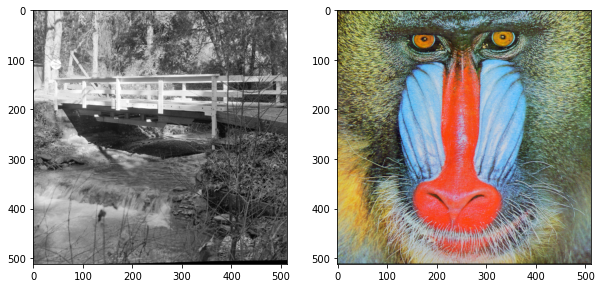

In [2]:
# -------------------
# --- Read images ---
# -------------------

import requests
from io import BytesIO

# Read images (images must be of the same size)
testImgs = ImgRead(enableJAX=False)

# Test images from the SIPI image database
fname = {0: requests.get('http://sipi.usc.edu/database/misc/5.2.10.tiff'),   # bridge (grayscale)
         1: requests.get('http://sipi.usc.edu/database/misc/boat.512.tiff'), # boat (grayscale)
         2: requests.get('http://sipi.usc.edu/database/misc/4.2.03.tiff'),   # mandrill (color)
         3: requests.get('http://sipi.usc.edu/database/misc/4.2.05.tiff'),   # airplane (color)
         4: requests.get('http://sipi.usc.edu/database/misc/4.2.07.tiff'),   # peppers (color)
        }

testImgs = ImgRead(enableJAX=False)        # If JAX is installed but just want to use 
                                           # standard numpy, then we need to pass this flag (once)

testImgs.list.append([BytesIO(fname.get(0).content),'g'])
testImgs.list.append([BytesIO(fname.get(2).content),'c'])
  

u = testImgs.readListImgs()                  # read list of images, normalize them between 0 and 1
                                             # u   : original image
                                             # obs : u corrupted with noise (depends on noiseModels)

        
pltImg  = ImgPlot()
pltImg.plotNImgs(u, len(u), None, 5)    



## Generate observed images

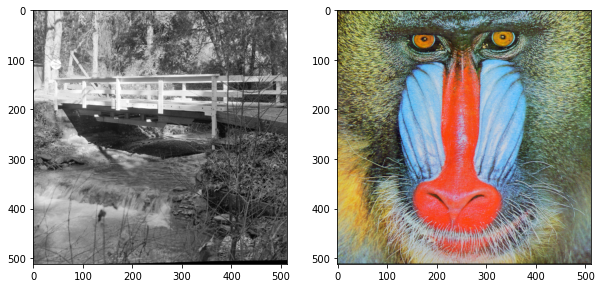

In [3]:
# --------------------------------------
# --- Set parameters for noise model ---
# --------------------------------------
    
noise = noiseModels(model=f2oDef.noise.Gaussian, sigma=0.0)
        
addNoise = noise.sel_NoiseModel()

z = addNoise(u)

pltImg.plotNImgs(z, len(z), None, 5)  

## Compute low / high pass filtered images

In [4]:
k = { 'bridge':   0,  # grayscale
      'mandrill': 1,  # color
    }.get('bridge')

uLP, uHP = testImgs.computeLPHP( z[k] , padFlag=True)

## Forward operator: randomly generated filterbank 

In [5]:

# Pre-computed dictionary
Dict = sio.loadmat('../../data/nsp_12x12x36_t40.mat')  
H = Dict['FB']

# Select *frequency domain* routines (note the "_f"
freqOp         = fwOp_f(linOp=f2oDef.fAx_FB2D, A=H)



## Setup optimziation problem

In [6]:
# -------------------------------------------------
# Define optimization class and general properties 
# -------------------------------------------------

args = F2O.argsF2O()

args.fCostClass  = f2oDef.cost.L2L1_lin    # f(x) = 0.5|| fAx(x) - b ||_2^2 + \lambda|| x ||_1
args.verbose     = True                    # Verbose ooutput
args.verboseStep = 5                       # default is 10

#args.padFlag     = False                   # padding in the Fourier domain
args.padFlag         = True
args.padMode         = 'symmetric'    
    
# -- specific parameters will be selected below
  

## Call the solver (FISTA, freq. domain)

In [10]:

# Execute 
#  
# >>> f2oDef.ss.printSS()
#
# to list all the available step-size policies

args.ISeqPolicy = f2oDef.iseq.ntrv      # inertial sequence
args.mulCte     = -1.                   # since variable 'args' is being reused, the 'mulCte'
                                        # value must be reset at every run of this cell

lmbda = 0.1
nIter = 50

x = []
Stats = []
solverSS  = []


# ---------------
# Dummy call (2 iterations only) -- this first call is 'slow'
args.ssPolicy  = f2oDef.ss.Cauchy       
sol = fAPG(freqOp, uHP, lmbda, 2, args)

# ---------------
# Cauchy
args.ssPolicy  = f2oDef.ss.Cauchy       
sol = fAPG(freqOp, uHP, lmbda, nIter, args)

x.append(sol[0])
Stats.append(sol[1])
solverSS.append(args.ssPolicy.name)


# ---------------
# Cauchylagged
args.ssPolicy  = f2oDef.ss.CauchyLagged       
sol = fAPG(freqOp, uHP, lmbda, nIter, args)

x.append(sol[0])
Stats.append(sol[1])
solverSS.append(args.ssPolicy.name)


# ---------------
# BBv1
args.ssPolicy  = f2oDef.ss.BBv1      
sol = fAPG(freqOp, uHP, lmbda, nIter, args)

x.append(sol[0])
Stats.append(sol[1])
solverSS.append(args.ssPolicy.name)


# ---------------
# BBv2
args.ssPolicy  = f2oDef.ss.BBv2
sol = fAPG(freqOp, uHP, lmbda, nIter, args)

x.append(sol[0])
Stats.append(sol[1])
solverSS.append(args.ssPolicy.name)


# ---------------
# Cuachy Supp
args.ssPolicy  = f2oDef.ss.CauchySupp
args.mulCte     = 0.5
sol = fAPG(freqOp, uHP, lmbda, nIter, args)

x.append(sol[0])
Stats.append(sol[1])
solverSS.append(args.ssPolicy.name)





Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 2.055e+03	 8.42e-04    4.34e-01    nan
  1	 1.739e+03	 8.68e-04    8.54e-01    4.640e-01


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 2.055e+03	 8.42e-04    3.95e-01    nan
  5	 9.095e+02	 1.14e-03    2.68e+00    1.610e-01
 10	 7.503e+02	 1.41e-03    5.08e+00    7.172e-02
 15	 6.975e+02	 1.27e-03    7.42e+00    4.860e-02
 20	 6.634e+02	 1.27e-03    9.72e+00    3.831e-02
 25	 6.405e+02	 1.27e-03    1.20e+01    3.224e-02
 30	 6.238e+02	 1.28e-03    1.43e+01    2.795e-02
 35	 6.109e+02	 1.28e-03    1.68e+01    2.468e-02
 40	 6.008e+02	 1.28e-03    1.91e+01    2.207e-02
 45	 5.926e+02	 1.28e-03    2.16e+01    1.995e-02
 49	 5.871e+02	 1.28e-03    2.35e+01    1.851e-02


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 2.055e+03	 8.42e-04    3.97e-01    nan
  5	 9.159e+02	 1.03e-03    2.56e+00    1.588e-01
 10	 7.531e+02	 1.41e-03    4.77e+00    7.277e-02
 15	 6.986e+02	 1.29e-03    7.02e+00    4.960e-02


## Show reconstructed images

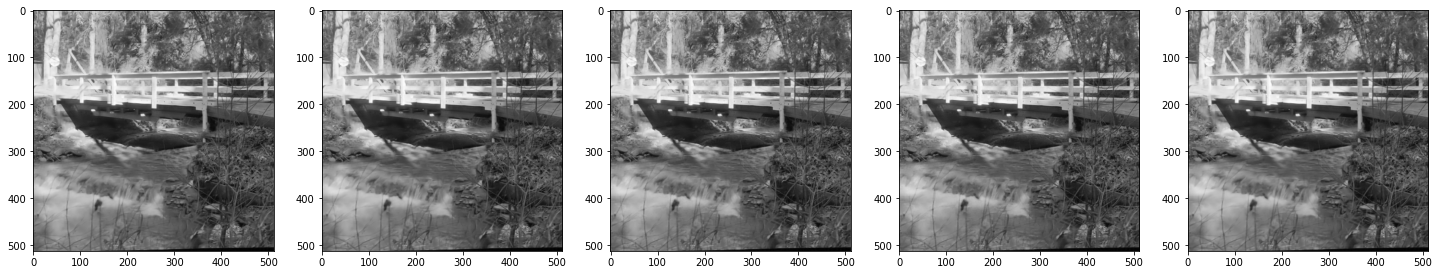

In [11]:
# Reconstruction
# ==============
  
uRec = []

for n in range( len(x) ):
    uRec.append( freqOp.fRec(x[n], uLP ) )       # uRec = fwOp(x) + uLP


pltImg  = ImgPlot()
pltImg.plotNImgs(uRec, len(uRec), None, 5)


[Text(0.5, 0, 'Time (sec.)')]

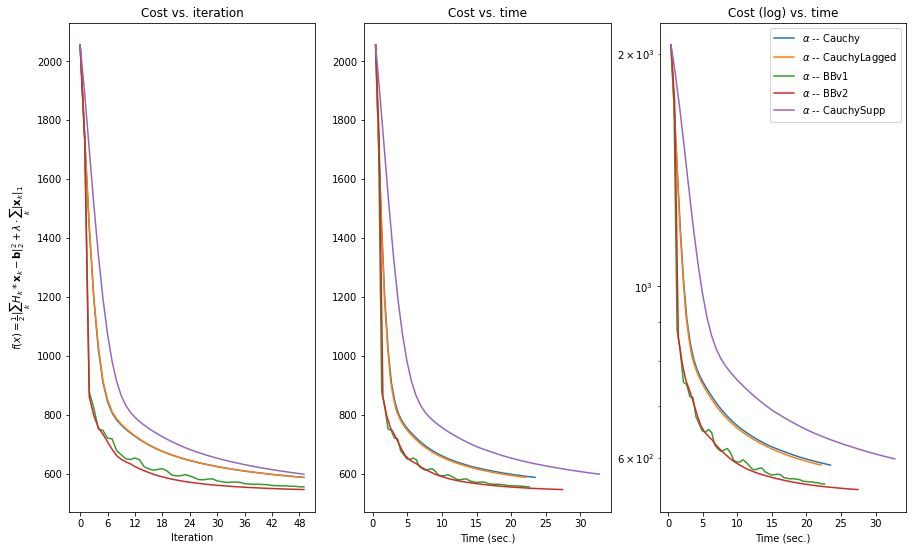

In [12]:
import matplotlib.pylab as PLT
from matplotlib.ticker import MaxNLocator

# Plot cost functional ---
figure, f = PLT.subplots(ncols=3, figsize=(15, 9))
  
for n in range(len(x)):
    f[0].plot(Stats[n][:,0], label=r'$\alpha$ -- {0}'.format(solverSS[n]) )
  
f[0].set_title('Cost vs. iteration')
f[0].xaxis.set_major_locator(MaxNLocator(integer=True))  
PLT.setp(f[0], xlabel='Iteration', 
           ylabel=r'$f(x) = \frac{1}{2}\left\| \sum_k H_k * \mathbf{x}_k - \mathbf{b} \right\|_2^2 + \lambda \cdot \sum_k \| \mathbf{x}_k \|_1$')
  
  
for n in range(len(x)):
    f[1].plot(Stats[n][:,2], Stats[n][:,0], label=r'solver -- {0}'.format(solverSS[n]) )

f[1].set_title('Cost vs. time')
PLT.setp(f[1], xlabel='Time (sec.)') 

    
for n in range(len(x)):
    f[2].semilogy(Stats[n][:,2], Stats[n][:,0], label=r'$\alpha$ -- {0}'.format(solverSS[n]) )
    
    
f[2].legend(loc='upper right',fontsize=10)
f[2].set_title('Cost (log) vs. time')
PLT.setp(f[2], xlabel='Time (sec.)') 
  